Link Kaggle
https://www.kaggle.com/bambanghpba/nlp-agree-disagree/

## Import Library

In [1]:
import re
import nltk
import string
import codecs
import warnings
import numpy as np
import pandas as pd
import fasttext.util
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

from tensorflow import keras
from tensorflow.keras import layers, models, initializers, regularizers, constraints, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, Embedding, Dropout, GlobalMaxPool1D, SpatialDropout1D, BatchNormalization, Bidirectional, LSTM, GlobalMaxPooling1D, MaxPooling1D, Flatten, GRU, Softmax
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import text, sequence

from tqdm import tqdm
from gensim.models.word2vec import Word2Vec

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

warnings.simplefilter(action="ignore", category=FutureWarning)

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Preparation

Menyiapkan fungsi-fungsi yang dibutuhkan untuk melakukan pemrosesan seperti pembangkit index embedding, matriks embedding, hingga preprocessing teks. 

In [2]:
lemmatizer = WordNetLemmatizer()

def fasttext_embedding():
    
    dictionary = {}
    file = codecs.open('../input/fast-text-embeddings-without-subwords/crawl-300d-2M.vec/crawl-300d-2M.vec', encoding='utf-8')
    for line in tqdm(file, desc="Load Vector Model "):
        values = line.rstrip().rsplit(' ')
        word, coefs = values[0], np.asarray(values[1:], dtype='float32')
        dictionary[word] = coefs
    file.close()
    return dictionary

def embedding_matrix(tokenizer, embeddings_index, size):
    embedding_matrix = np.zeros((len(tokenizer.word_index)+1, size))

    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

def longest_sentence(sentences):
    max = 0
    idx = 0
    for i in range(len(sentences)):
        words = sentences[i].split(' ')
        if(len(words) > max):
            max = len(words)
            idx = i
    return max, idx

def label_encoding(label):
    if(label == 'agreement'):
        return 0
    elif(label == 'disagreement'):
        return 1
    else:
        return 2
    
def fact_label_encoding(label):
    if(label == 'feeling-based'):
        return 0
    elif(label == 'fact-based'):
        return 1
    else:
        return 2

def agreement_label_encoding(label):
    if(label == 'disagreement'):
        return 0
    elif(label == 'agreement'):
        return 1
    else:
        return 2
    
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
    
def lemmatize_sentence(sentence):

    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

def sentence_pos_tag(sentence):
    text = word_tokenize(sentence)
    pos_tag = nltk.pos_tag(text)
    pos_tag_res = ''
    for i in range(len(pos_tag)):
        pos_tag_res += pos_tag[i][1]
        pos_tag_res += ' ' if i != len(sentence)-1 else '' 
    return pos_tag_res

def preprocessing(text):
    text = text.lower()
    text = text.strip()
    text = re.sub(r" \d+ ", " ", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"[^a-z ]", "", text)
    text = re.sub(r"  ", " ", text)
    text = lemmatize_sentence(text)
    return text

In [3]:
import pickle

file = open("../input/quote-response/quotexresponseprocessed.pkl", "rb")
df = pickle.load(file)
file.close()
print(df.head())

                                     presented_quote  \
0  i get a good idea however they do tend to stay...   
1  be sure to give your gun a big fat kiss tonigh...   
2  one of the big argument against gun control be...   
3  first of all compare the b specimen in your fo...   
4  there be some incedents that be beyond your co...   

                                  presented_response   emotion_fact  \
0  by your own admission you havent hang out with...  feeling-based   
1  actually they didnt the whole tragedy be cause...         unsure   
2  not quite to be more correct regard government...     fact-based   
3  at your servicecomparisoni couldve just circle...         unsure   
4                                           well yes  feeling-based   

  disagree_agree plain_sarcasm  \
0   disagreement        unsure   
1   disagreement        unsure   
2   disagreement    no_sarcasm   
3   disagreement        unsure   
4      agreement    no_sarcasm   

                               

In [4]:
df = df[df['emotion_fact'] != 'unsure']
df = df.loc[:, ['presented_quote', 'presented_response', 'disagree_agree', 'presented_response_tag', 'emotion_fact']]
df

,presented_quote,presented_response,disagree_agree,presented_response_tag,emotion_fact
0,i get a good idea however they do tend to stay...,by your own admission you havent hang out with...,disagreement,IN PRP$ JJ NN PRP VBP VB RP IN NN IN DT NN CC ...,feeling-based
2,one of the big argument against gun control be...,not quite to be more correct regard government...,disagreement,RB RB TO VB RBR JJ JJ NN CC VB DT NN TO VB NN ...,fact-based
4,there be some incedents that be beyond your co...,well yes,agreement,RB RB,feeling-based
6,legality do not matter religous implication do...,exact to the point amp beautiful,agreement,NN TO DT NN NN NN,feeling-based
8,once again you seem to support the killing of ...,base on the idea that people be dispensible pa...,unsure,NN IN DT NN WDT NNS VB JJ RB IN PRP VBP PRP$ V...,feeling-based
...,...,...,...,...,...
9977,the id movement form of id state that there be...,that of course be the logical fallacy know as ...,disagreement,DT IN NN VB DT JJ NN VBP IN JJ NN DT NN PRP VB...,fact-based
9978,for me it would therefore have make no differe...,it logically follow from the moral foundation ...,agreement,PRP RB VBP IN DT JJ NN VBN RP CC PRP VBP TO JJ...,feeling-based
9979,good thing this argument have never be doneoh ...,and teen sex doesnt by the very nature of its ...,unsure,CC JJ NN NN IN DT JJ NN IN PRP$ NN NN IN NN DT...,feeling-based
9980,i know one thing anything that happen politica...,wasnt sinjin crow about his plan to take the f...,unsure,NN NN NN IN PRP$ NN TO VB DT NN NN CC NN TO DT...,feeling-based


In [5]:
df['presented_quote'] = df['presented_quote'].apply(lambda x: preprocessing(x))
df['presented_response'] = df['presented_response'].apply(lambda x: preprocessing(x))
df['disagree_agree'] = df['disagree_agree'].apply(lambda x: agreement_label_encoding(x))
df['emotion_fact'] = df['emotion_fact'].apply(lambda x: fact_label_encoding(x))

In [6]:
df.shape

(5850, 5)

In [7]:
df = df[~df['emotion_fact'].isin([2])]
df = df[~df['disagree_agree'].isin([2])]

In [8]:
df.shape

(4409, 5)

In [9]:
from sklearn.model_selection import train_test_split

X = df.loc[:, ['presented_quote', 'presented_response', 'emotion_fact']]
y = df.loc[:, ['disagree_agree']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=20)

In [10]:
y.value_counts()

disagree_agree
0                 3709
1                  700
dtype: int64

In [11]:
print(y_train.value_counts())
print(y_test.value_counts())

disagree_agree
0                 3147
1                  600
dtype: int64
disagree_agree
0                 562
1                 100
dtype: int64


In [12]:
X_train_quotes = X_train['presented_quote'].values
X_train_responses = X_train['presented_response'].values
X_train_emotion = X_train['emotion_fact'].values

X_test_quotes = X_test['presented_quote'].values
X_test_responses = X_test['presented_response'].values
X_test_emotion = X_test['emotion_fact'].values

y_train = y_train['disagree_agree'].values
y_test = y_test['disagree_agree'].values

X_train_text = X_train_quotes + X_train_responses

In [13]:
tokenizer = Tokenizer(num_words=300000)
tokenizer.fit_on_texts(list(X_train_text))

X_train_quotes = tokenizer.texts_to_sequences(X_train_quotes)
X_train_responses = tokenizer.texts_to_sequences(X_train_responses)
X_test_quotes = tokenizer.texts_to_sequences(X_test_quotes)
X_test_responses = tokenizer.texts_to_sequences(X_test_responses)

X_train_quotes = sequence.pad_sequences(X_train_quotes, maxlen=1000)
X_train_responses = sequence.pad_sequences(X_train_responses, maxlen=1000)
X_test_quotes = sequence.pad_sequences(X_test_quotes, maxlen=1000)
X_test_responses = sequence.pad_sequences(X_test_responses, maxlen=1000)


In [14]:
file = open("tokenizer.pkl", "wb")
pickle.dump(tokenizer, file)
file.close()

In [15]:
print(X_train_quotes.shape)
print(X_train_responses.shape)
print(X_test_quotes.shape)
print(X_test_responses.shape)

(3747, 1000)
(3747, 1000)
(662, 1000)
(662, 1000)


In [16]:
fasttext_index = fasttext_embedding()
fasttext_matrix = embedding_matrix(tokenizer, fasttext_index, 300)

Load Vector Model : 1999996it [05:11, 6429.91it/s]


In [17]:
file = open("fasttext_matrix.pkl", "wb")
pickle.dump(fasttext_matrix, file)
file.close()

In [18]:
quote_input    = keras.Input(shape=(None,), name='quote')
response_input = keras.Input(shape=(None,), name='response')
emotion_input = keras.Input(shape=(1,), name='emotion')
quote_feature    = layers.Embedding(fasttext_matrix.shape[0], input_length=1000, output_dim=fasttext_matrix.shape[1], weights=[fasttext_matrix], trainable=False)(quote_input)
response_feature = layers.Embedding(fasttext_matrix.shape[0], input_length=1000, output_dim=fasttext_matrix.shape[1], weights=[fasttext_matrix], trainable=False)(response_input)
quote_feature    = layers.Bidirectional(GRU(100, return_sequences=False))(quote_feature)
response_feature = layers.Bidirectional(GRU(100, return_sequences=False))(response_feature)
double = layers.concatenate([quote_feature, response_feature, emotion_input])
dense1  = layers.Dense(200, activation='relu')(double)
dense2  = layers.Dense(200, activation='relu')(dense1)
dense3  = layers.Dense(200, activation='relu')(dense2)
pred   = layers.Dense(3, activation='softmax', name='agree_disagree')(dense3)

model = keras.Model(inputs=[quote_input, response_input, emotion_input], outputs=[pred],)

2021-11-16 22:24:15.532086: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-16 22:24:15.655218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-16 22:24:15.656084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-16 22:24:15.657474: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
quote (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
response (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    7827600     quote[0][0]                      
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    7827600     response[0][0]                   
______________________________________________________________________________________________

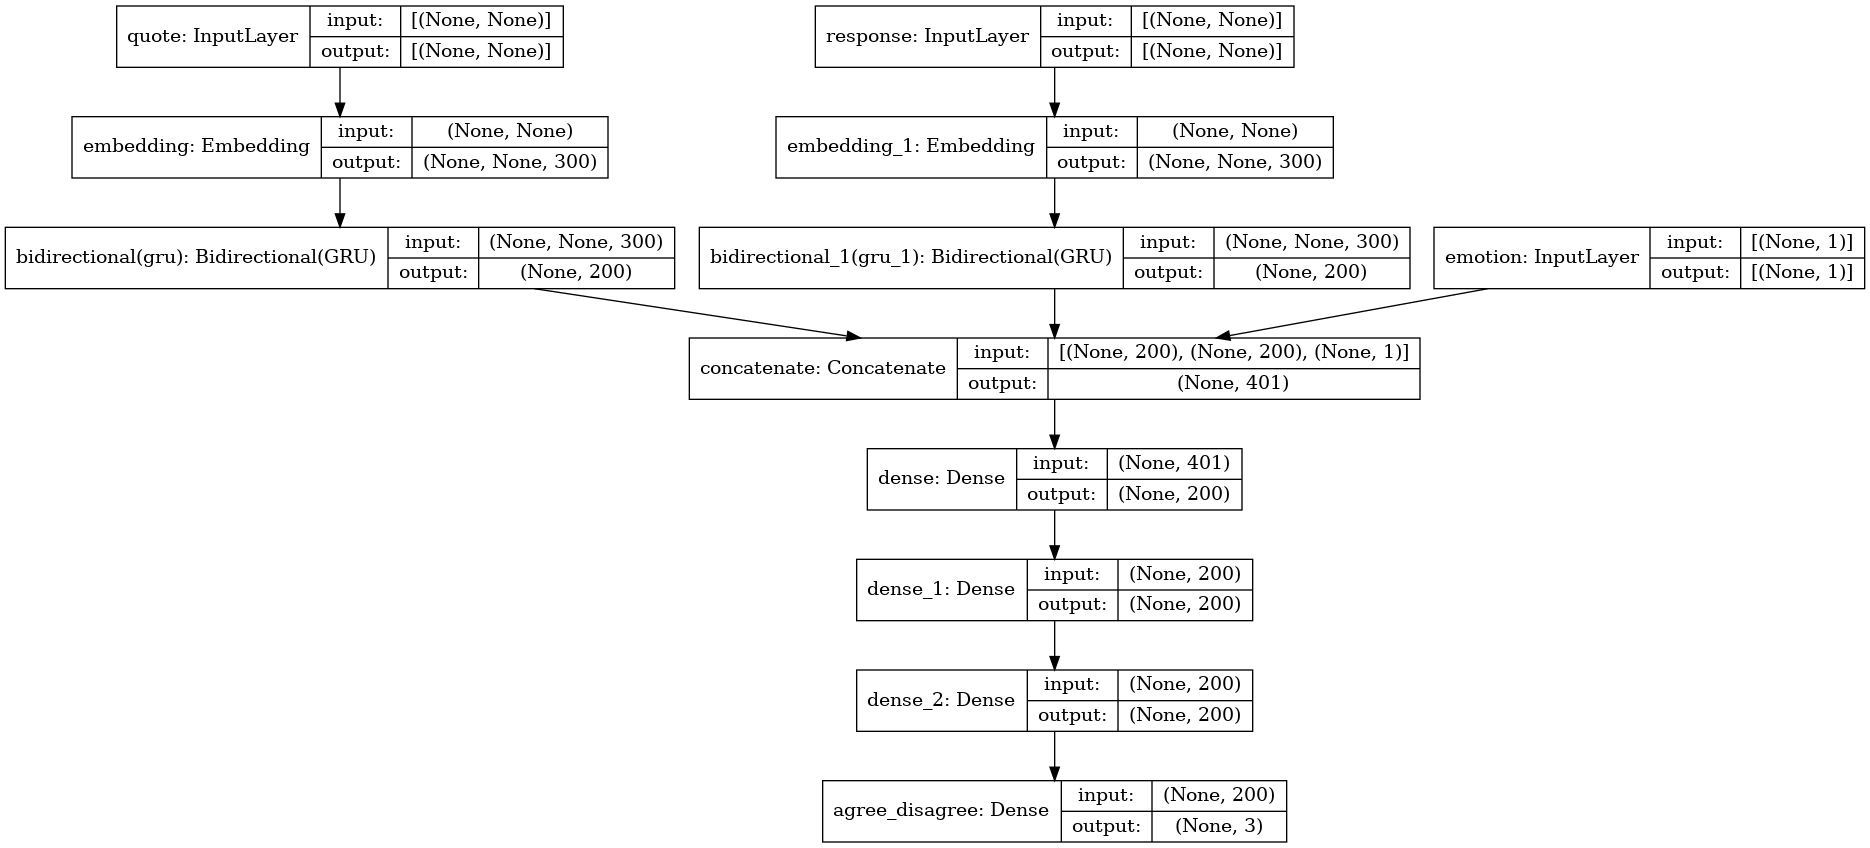

In [20]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

In [21]:
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.fit(
    {'quote': X_train_quotes, 'response': X_train_responses, 'emotion': X_train_emotion},
    {'agree_disagree': y_train},
    epochs=10,
    batch_size=32,
    validation_split=0.1
)

2021-11-16 22:24:24.852802: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2021-11-16 22:24:31.082320: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


106/106 [==============================] - 25s 168ms/step - loss: 0.4647 - accuracy: 0.8399 - val_loss: 0.4363 - val_accuracy: 0.8293
Epoch 2/10
106/106 [==============================] - 17s 156ms/step - loss: 0.4013 - accuracy: 0.8425 - val_loss: 0.4590 - val_accuracy: 0.8373
Epoch 3/10
106/106 [==============================] - 17s 157ms/step - loss: 0.3524 - accuracy: 0.8612 - val_loss: 0.4285 - val_accuracy: 0.8400
Epoch 4/10
106/106 [==============================] - 17s 156ms/step - loss: 0.2895 - accuracy: 0.8817 - val_loss: 0.4372 - val_accuracy: 0.8427
Epoch 5/10
106/106 [==============================] - 17s 157ms/step - loss: 0.1992 - accuracy: 0.9190 - val_loss: 0.5735 - val_accuracy: 0.8320
Epoch 6/10
106/106 [==============================] - 17s 156ms/step - loss: 0.1371 - accuracy: 0.9434 - val_loss: 0.6746 - val_accuracy: 0.8347
Epoch 7/10
106/106 [==============================] - 17s 157ms/step - loss: 0.0909 - accuracy: 0.9677 - val_loss: 0.8827 - val_accuracy: 0.8

In [22]:
prediction = model.predict({'quote': X_test_quotes, 'response': X_test_responses, 'emotion': X_test_emotion})

In [23]:
prediction

array([[9.7962475e-01, 2.0363459e-02, 1.1828407e-05],
       [9.9995518e-01, 4.4782384e-05, 3.7335646e-10],
       [9.9999940e-01, 5.9079406e-07, 1.0637642e-13],
       ...,
       [9.9962890e-01, 3.7102765e-04, 3.4811102e-08],
       [4.8947844e-01, 5.1039410e-01, 1.2749639e-04],
       [9.9969077e-01, 3.0922299e-04, 1.6440321e-08]], dtype=float32)

In [24]:
r = []
for predict in prediction:
    label = np.argmax(predict)
    r.append(label)
    
r = np.array(r)

r

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,

In [25]:
from sklearn.metrics import classification_report
print(classification_report(r, y_test))

              precision    recall  f1-score   support

           0       0.91      0.86      0.89       593
           1       0.19      0.28      0.22        69

    accuracy                           0.80       662
   macro avg       0.55      0.57      0.56       662
weighted avg       0.84      0.80      0.82       662



In [26]:
# file = open("double_biGRU_with_emotion_model.pkl", "wb")
# pickle.dump(model, file)
# file.close()
model.save("double_biGRU_with_emotion_model.h5")

In [27]:
quote_input    = keras.Input(shape=(None,), name='quote')
response_input = keras.Input(shape=(None,), name='response')
quote_feature    = layers.Embedding(fasttext_matrix.shape[0], input_length=1000, output_dim=fasttext_matrix.shape[1], weights=[fasttext_matrix], trainable=False)(quote_input)
response_feature = layers.Embedding(fasttext_matrix.shape[0], input_length=1000, output_dim=fasttext_matrix.shape[1], weights=[fasttext_matrix], trainable=False)(response_input)
quote_feature    = layers.Bidirectional(GRU(100, return_sequences=False))(quote_feature)
response_feature = layers.Bidirectional(GRU(100, return_sequences=False))(response_feature)
double = layers.concatenate([quote_feature, response_feature])
dense1  = layers.Dense(200, activation='relu')(double)
dense2  = layers.Dense(200, activation='relu')(dense1)
dense3  = layers.Dense(200, activation='relu')(dense2)
pred   = layers.Dense(3, activation='softmax', name='agree_disagree')(dense3)

model = keras.Model(inputs=[quote_input, response_input], outputs=[pred],)

In [28]:
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.fit(
    {'quote': X_train_quotes, 'response': X_train_responses},
    {'agree_disagree': y_train},
    epochs=10,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/10
106/106 [==============================] - 23s 167ms/step - loss: 0.4601 - accuracy: 0.8402 - val_loss: 0.4429 - val_accuracy: 0.8293
Epoch 2/10
106/106 [==============================] - 17s 157ms/step - loss: 0.4142 - accuracy: 0.8413 - val_loss: 0.4292 - val_accuracy: 0.8320
Epoch 3/10
106/106 [==============================] - 17s 157ms/step - loss: 0.3727 - accuracy: 0.8499 - val_loss: 0.4180 - val_accuracy: 0.8373
Epoch 4/10
106/106 [==============================] - 17s 156ms/step - loss: 0.3113 - accuracy: 0.8760 - val_loss: 0.4885 - val_accuracy: 0.8373
Epoch 5/10
106/106 [==============================] - 17s 157ms/step - loss: 0.2224 - accuracy: 0.9125 - val_loss: 0.4908 - val_accuracy: 0.8400
Epoch 6/10
106/106 [==============================] - 17s 157ms/step - loss: 0.1505 - accuracy: 0.9380 - val_loss: 0.7027 - val_accuracy: 0.8107
Epoch 7/10
106/106 [==============================] - 17s 157ms/step - loss: 0.0932 - accuracy: 0.9674 - val_loss: 0.8897 - val_ac

In [29]:
prediction = model.predict({'quote': X_test_quotes, 'response': X_test_responses})

In [30]:
prediction

array([[9.9999774e-01, 2.3012635e-06, 4.2625430e-13],
       [9.9942493e-01, 5.7510106e-04, 2.5929565e-09],
       [9.9996424e-01, 3.5813078e-05, 1.0950401e-10],
       ...,
       [9.9999869e-01, 1.2872837e-06, 4.9615307e-14],
       [5.0058751e-03, 9.9499375e-01, 3.6234914e-07],
       [9.8336792e-01, 1.6622867e-02, 9.2403743e-06]], dtype=float32)

In [31]:
r = []
for predict in prediction:
    label = np.argmax(predict)
    r.append(label)
    
r = np.array(r)

r

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,

In [32]:
from sklearn.metrics import classification_report
print(classification_report(r, y_test))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       593
           1       0.15      0.22      0.18        69

    accuracy                           0.79       662
   macro avg       0.53      0.54      0.53       662
weighted avg       0.83      0.79      0.81       662



In [33]:
model.save("double_biGRU.h5")

In [34]:
import re
def agree_predict(quote, response, emotion):
    model = keras.models.load_model('double_biGRU_with_emotion_model.h5')
    q = tokenizer.texts_to_sequences(np.array([preprocessing(quote)]))
    r = tokenizer.texts_to_sequences(np.array([preprocessing(response)]))
    e = fact_label_encoding(emotion)
    q = sequence.pad_sequences(q, maxlen=1000)
    r = sequence.pad_sequences(r, maxlen=1000)
    e = np.array([e])
    p = model.predict({'quote': q, 'response':r, 'emotion':e})
    return np.argmax(p)

a = "I am against suicide because you are basically not only harming yourself, but everyone else around you. Let’s not mention it is a cowards way out. I also have a religious but I CAN explain that reason."
b = "So true man people only harm the people they love by dying. I am not religious and religiously and non-religiously suicide is wrong."

c = "The majority of the information learned in school is irrelevant to real world skills. Besides, in a voluntary setting, most children would go to school via parents demands where school choice would be much more abundant."
d = "Children learn math which is relevant, children learn history which is relvant, children learn the releveant languge to their country, children learn foreign languages which imporoves economic opportunites. My one friend grew up in Baghdad, Iraq, and they don’t play when it comes to education. He started learning English in the 3rd grade I think through graduation which helped his economic ooportunities, and he is an artchitect so the math helped. Please excuse my typos. I have a learning disability"

pr = agree_predict(c, d, "feeling-based")
print(pr)
    

1


In [35]:
import pickle

file = open("../input/quote-response/quotexresponseprocessed.pkl", "rb")
df = pickle.load(file)
file.close()
print(df.head())

                                     presented_quote  \
0  i get a good idea however they do tend to stay...   
1  be sure to give your gun a big fat kiss tonigh...   
2  one of the big argument against gun control be...   
3  first of all compare the b specimen in your fo...   
4  there be some incedents that be beyond your co...   

                                  presented_response   emotion_fact  \
0  by your own admission you havent hang out with...  feeling-based   
1  actually they didnt the whole tragedy be cause...         unsure   
2  not quite to be more correct regard government...     fact-based   
3  at your servicecomparisoni couldve just circle...         unsure   
4                                           well yes  feeling-based   

  disagree_agree plain_sarcasm  \
0   disagreement        unsure   
1   disagreement        unsure   
2   disagreement    no_sarcasm   
3   disagreement        unsure   
4      agreement    no_sarcasm   

                               

In [36]:
df = df.loc[:, ['presented_quote', 'presented_response', 'disagree_agree', 'presented_response_tag', 'emotion_fact']]

In [37]:
df['presented_quote'] = df['presented_quote'].apply(lambda x: preprocessing(x))
df['presented_response'] = df['presented_response'].apply(lambda x: preprocessing(x))
df['disagree_agree'] = df['disagree_agree'].apply(lambda x: agreement_label_encoding(x))
df['emotion_fact'] = df['emotion_fact'].apply(lambda x: fact_label_encoding(x))

In [38]:
from sklearn.model_selection import train_test_split

X = df.loc[:, ['presented_quote', 'presented_response', 'emotion_fact']]
y = df.loc[:, ['disagree_agree']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=20)

In [39]:
X_train_quotes = X_train['presented_quote'].values
X_train_responses = X_train['presented_response'].values
X_train_emotion = X_train['emotion_fact'].values

X_test_quotes = X_test['presented_quote'].values
X_test_responses = X_test['presented_response'].values
X_test_emotion = X_test['emotion_fact'].values
y_train = y_train['disagree_agree'].values
y_test = y_test['disagree_agree'].values

X_train_text = X_train_quotes + X_train_responses

In [40]:
tokenizer = Tokenizer(num_words=300000)
tokenizer.fit_on_texts(list(X_train_text))

X_train_quotes = tokenizer.texts_to_sequences(X_train_quotes)
X_train_responses = tokenizer.texts_to_sequences(X_train_responses)
X_test_quotes = tokenizer.texts_to_sequences(X_test_quotes)
X_test_responses = tokenizer.texts_to_sequences(X_test_responses)

X_train_quotes = sequence.pad_sequences(X_train_quotes, maxlen=1000)
X_train_responses = sequence.pad_sequences(X_train_responses, maxlen=1000)
X_test_quotes = sequence.pad_sequences(X_test_quotes, maxlen=1000)
X_test_responses = sequence.pad_sequences(X_test_responses, maxlen=1000)

In [41]:
quote_input    = keras.Input(shape=(None,), name='quote')
response_input = keras.Input(shape=(None,), name='response')

emotion_input = keras.Input(shape=(1,), name='emotion')

quote_feature    = layers.Embedding(fasttext_matrix.shape[0], input_length=1000, output_dim=fasttext_matrix.shape[1], weights=[fasttext_matrix], trainable=False)(quote_input)
response_feature = layers.Embedding(fasttext_matrix.shape[0], input_length=1000, output_dim=fasttext_matrix.shape[1], weights=[fasttext_matrix], trainable=False)(response_input)

quote_feature    = layers.Bidirectional(GRU(100, return_sequences=False))(quote_feature)
# quote_feature    = layers.LSTM(100, return_sequences=False)(quote_feature)

response_feature = layers.Bidirectional(GRU(100, return_sequences=False))(response_feature)
# response_feature = layers.LSTM(25, return_sequences=False)(response_feature)

# emotion_feature = layers.Dense(1, activation='relu')(emotion_input)

double = layers.concatenate([quote_feature, response_feature, emotion_input])

dense1  = layers.Dense(200, activation='relu')(double)

# dense  = layers.Dropout(0.3)(dense)  
dense2  = layers.Dense(200, activation='relu')(dense1)

dense3  = layers.Dense(200, activation='relu')(dense2)

pred   = layers.Dense(3, activation='softmax', name='agree_disagree')(dense3)

model = keras.Model(inputs=[quote_input, response_input, emotion_input], outputs=[pred],)


In [42]:
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.fit(
    {'quote': X_train_quotes, 'response': X_train_responses, 'emotion': X_train_emotion},
    {'agree_disagree': y_train},
    epochs=10,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/10
239/239 [==============================] - 43s 161ms/step - loss: 0.8978 - accuracy: 0.6130 - val_loss: 0.8804 - val_accuracy: 0.6172
Epoch 2/10
239/239 [==============================] - 37s 156ms/step - loss: 0.8480 - accuracy: 0.6224 - val_loss: 0.8932 - val_accuracy: 0.6113
Epoch 3/10
239/239 [==============================] - 37s 156ms/step - loss: 0.7857 - accuracy: 0.6468 - val_loss: 0.9026 - val_accuracy: 0.5960
Epoch 4/10
239/239 [==============================] - 37s 156ms/step - loss: 0.6856 - accuracy: 0.6954 - val_loss: 1.0114 - val_accuracy: 0.5995
Epoch 5/10
239/239 [==============================] - 37s 156ms/step - loss: 0.5474 - accuracy: 0.7639 - val_loss: 1.1216 - val_accuracy: 0.5442
Epoch 6/10
239/239 [==============================] - 37s 156ms/step - loss: 0.3876 - accuracy: 0.8418 - val_loss: 1.3415 - val_accuracy: 0.5795
Epoch 7/10
239/239 [==============================] - 37s 156ms/step - loss: 0.2498 - accuracy: 0.9053 - val_loss: 1.8724 - val_ac

In [43]:
prediction = model.predict({'quote': X_test_quotes, 'response': X_test_responses, 'emotion': X_test_emotion})

In [44]:
r = []
for predict in prediction:
    label = np.argmax(predict)
    r.append(label)
    
r = np.array(r)

r

array([0, 0, 0, ..., 0, 2, 2])

In [45]:
from sklearn.metrics import classification_report
print(classification_report(r, y_test))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68       943
           1       0.16      0.23      0.19       124
           2       0.32      0.28      0.30       431

    accuracy                           0.53      1498
   macro avg       0.39      0.40      0.39      1498
weighted avg       0.53      0.53      0.53      1498

